# Watch a temperature : scan temperature *v* time

From *2021-03 APS Python Training for Bluesky Data Acquisition*.

**Objective**

Measure the temperature for a short period and compute basics measures of the collected readings.

## Start the `instrument` package

In [1]:
from instrument.collection import *

I Wed-09:11:46 - ############################################################ startup
I Wed-09:11:46 - logging started
I Wed-09:11:46 - logging level = 10
I Wed-09:11:46 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/collection.py
I Wed-09:11:46 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/mpl/notebook.py
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
I Wed-09:11:46 - bluesky framework
I Wed-09:11:46 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/framework/check_python.py
I Wed-09:11:46 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/framework/check_bluesky.py
I Wed-09:11:47 - /home/mi

## Describe

Note the initial settings of the `temperature` (controller).  It's actually an EPICS *swait* record that simulates a temperature sensor and controller.  It has a setpoint, a readback, and a few other support attributes as shown.  A Random noise level is part of the simulation.  We'll compute that noise level from the standard deviation of the measurements.

In [2]:
listdevice(temperature)

============================= =================================== ==========================
name                          value                               timestamp                 
============================= =================================== ==========================
temperature_setpoint          25.0                                2021-02-24 09:11:53.926844
temperature_readback          25.0                                2021-02-24 09:11:53.928213
temperature_done              True                                2021-02-24 09:11:53.929249
temperature_calculation       A+max(-D,min(D,(B-A)))+C*(RNDM-0.5) 2021-02-24 09:11:53.928542
temperature_description       temperature                         2021-02-24 09:11:53.925579
temperature_max_change        2.0                                 2021-02-24 09:11:53.928417
temperature_noise             1.0                                 2021-02-24 09:11:53.928213
temperature_previous_value_pv gp:userCalc8.VAL                    2021

## Count
Use the bluesky RunEngine, `RE`, and a standard plan, `bp.count()`, to count the temperature.

In [3]:
RE(bp.count([temperature]))



Transient Scan ID: 260     Time: 2021-02-24 09:11:53
Persistent Unique Scan ID: 'de793d7c-7167-4288-895f-bf86adcb1b78'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | temperature_readback |
+-----------+------------+----------------------+
|         1 | 09:11:54.4 |             25.00000 |
+-----------+------------+----------------------+
generator count ['de793d7c'] (scan num: 260)


('de793d7c-7167-4288-895f-bf86adcb1b78',)

Take ten readings by adding the `num=10` keyword argument (a.k.a. *kwarg*).



Transient Scan ID: 261     Time: 2021-02-24 09:11:54
Persistent Unique Scan ID: '5097dbe6-a184-4acb-b6b7-a32887afc2ca'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | temperature_readback |
+-----------+------------+----------------------+
|         1 | 09:11:55.3 |             24.65315 |
|         2 | 09:11:55.5 |             24.65315 |
|         3 | 09:11:55.5 |             24.65315 |
|         4 | 09:11:55.6 |             24.65315 |
|         5 | 09:11:55.6 |             24.65315 |
|         6 | 09:11:55.7 |             24.65315 |
|         7 | 09:11:55.7 |             24.65315 |
|         8 | 09:11:55.8 |             24.65315 |
|         9 | 09:11:55.8 |             24.65315 |
|        10 | 09:11:55.9 |             24.65315 |
+-----------+------------+----------------------+
generator count ['5097dbe6'] (scan num: 261)


('5097dbe6-a184-4acb-b6b7-a32887afc2ca',)

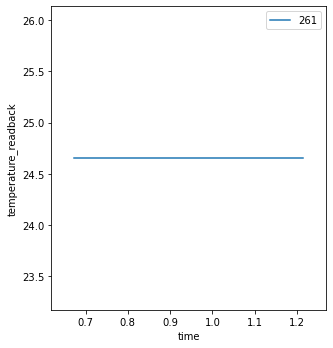

In [4]:
RE(bp.count([temperature], num=10))

Do all the readings look the same?  Perhaps there are only two different values (first one, then the other)?  That's because our measurements were only *reading* the temperature without waiting for it to update.  (If there are two different values, we caught the moment when EPICS updated the calculation.)  The table above showed `temperature_scanning_rate 5` which means the EPICS is only updating every 2 seconds.

In [5]:
temperature.scanning_rate.get(as_string=True)

'2 second'

## Adjust the measurement interval
We need to slow down the measurement to this interval by adding the `delay=2` kwarg, sampling every 2 seconds.



Transient Scan ID: 262     Time: 2021-02-24 09:11:56
Persistent Unique Scan ID: 'd2084169-2a59-4a49-8bd6-902651d3260f'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | temperature_readback |
+-----------+------------+----------------------+
|         1 | 09:11:57.1 |             24.65315 |
|         2 | 09:11:59.0 |             25.09055 |
|         3 | 09:12:01.0 |             25.35870 |
|         4 | 09:12:03.0 |             25.41096 |
|         5 | 09:12:05.0 |             25.45364 |
|         6 | 09:12:07.0 |             24.73111 |
|         7 | 09:12:09.0 |             24.73290 |
|         8 | 09:12:11.0 |             24.88502 |
|         9 | 09:12:13.0 |             24.53828 |
|        10 | 09:12:15.0 |             24.81601 |
+-----------+------------+----------------------+
generator count ['d2084169'] (scan num: 262)


('d2084169-2a59-4a49-8bd6-902651d3260f',)

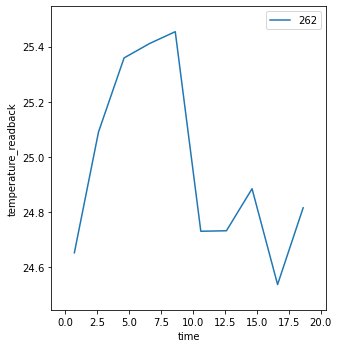

In [6]:
RE(bp.count([temperature], num=10, delay=2))

Let's reduce the update interval that EPICS uses, to the shortest interval EPICS provides, so our measurements do not take so long.

In [7]:
# print the list of possible values
print(temperature.scanning_rate.enum_strs)

# set the shortest interval, by name
temperature.scanning_rate.put(".1 second")
temperature.scanning_rate.get(as_string=True)

('Passive', 'Event', 'I/O Intr', '10 second', '5 second', '2 second', '1 second', '.5 second', '.2 second', '.1 second')


'.1 second'

## Collect our measurements
Repeat the measurement, this time with more observations.



Transient Scan ID: 263     Time: 2021-02-24 09:12:17
Persistent Unique Scan ID: '0c869050-541f-4344-831a-2a8672449eb0'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | temperature_readback |
+-----------+------------+----------------------+
|         1 | 09:12:18.2 |             24.83397 |
|         2 | 09:12:18.3 |             24.75042 |
|         3 | 09:12:18.4 |             24.57398 |
|         4 | 09:12:18.5 |             25.09548 |
|         5 | 09:12:18.6 |             24.55441 |
|         6 | 09:12:18.7 |             25.10729 |
|         7 | 09:12:18.8 |             24.65961 |
|         8 | 09:12:18.9 |             25.36984 |
|         9 | 09:12:19.0 |             25.13761 |
|        10 | 09:12:19.1 |             25.13897 |
|        11 | 09:12:19.2 |             25.00108 |
|        12 | 09:12:19.3 |             25.30452 |
|        13 | 09:12:19.4 |             24.99764 |
|        14 | 09:12:19.5 |        

('0c869050-541f-4344-831a-2a8672449eb0',)

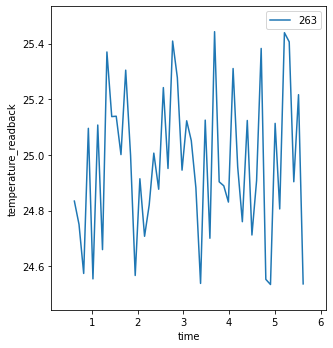

In [8]:
RE(bp.count([temperature], num=50, delay=0.1))

## Get the data (from the database)
Let's get the measured data from the database now.  It's the most recent bluesky run, so an index of `-1` will identify it.

In [9]:
dataset = db.v2[-1].primary.read()

Let's get the values as a 1-D numpy array.

In [10]:
T = dataset["temperature_readback"].values

## Compute the statistics
Use the methods of numpy arrays to compute maximum, mean, standard deviation, and minimum.  Looks nicer in a table.

In [11]:
table = pyRestTable.Table()
table.addLabel("measure")
table.addLabel("value")
table.addRow(("max", T.max()))
table.addRow(("mean", T.mean()))
table.addRow(("dev", T.std()))
table.addRow(("min", T.min()))
table.addRow(("#", len(T)))
print(table)

======= ==================
measure value             
======= ==================
max     25.442748149843595
mean    24.967728389410237
dev     0.2668641474466599
min     24.534195468070497
#       50                
======= ==================



Let's replot that data for comparison.

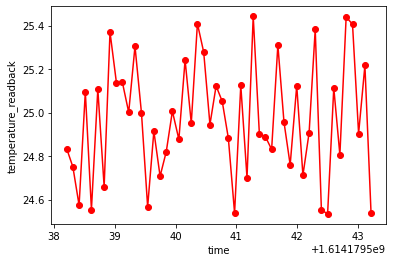

In [12]:
dataset["temperature_readback"].plot(marker="o", color="red")